# Statistical test POC

In [2]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

import datetime

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt

from google.cloud import bigquery
bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-super-dev')

In [3]:
sql = '''
    SELECT 
        campaign_start_date,
        crn,
        model,
        SUM(weekly_inc_sales) AS inc_sales
    FROM `gcp-wow-rwds-ai-mmm-prod.PROD_MMM.MMM_POST_BQ_MASTER_AUDIENCE`
    WHERE campaign_start_date IN (
        '2021-12-06',
        '2021-11-22', 
        '2021-11-08'
    )
    GROUP BY 1,2,3
'''

df = bq.query(sql).result().to_dataframe()

In [ ]:
_df = df[df['campaign_start_date'] == datetime.datetime.strptime('2021-12-06', '%Y-%m-%d').date()]

In [12]:
# _df = df.copy()

df_r = _df[_df['model'] == 'R']
df_m = _df[_df['model'] == 'M']

df_r = df_r.sample(n=100000, random_state=1)
df_m = df_m.sample(n=100000, random_state=1)

### Welch's t-test

In [14]:
def welch(df_0, df_1, metric='inc_sales', simu_size=1000000):
    
    # Evaluate size
    n0 = df_0.shape[0]
    n1 = df_1.shape[0]
    
    # Evaluate sample means
    m0 = df_0[metric].mean()
    m1 = df_1[metric].mean()
    
    # Evaluate sample standard deviation
    _s0 = df_0[metric].std()
    _s1 = df_1[metric].std()
    
    # Evaluate standard error
    s0 = _s0 / np.sqrt(n0)
    s1 = _s1  / np.sqrt(n1)
    
    # Make sure DOF is greater than 1,000 to estimate normal distribution
    dof = (_s0**2/n0 + _s1**2/n1) ** 2 / (_s0 ** 4 / n0**2 / (n0-1) + _s1 ** 4 / n1**2 / (n1-1))
    assert dof > 1000, "Not enough samples to estimate for normal distribution"
    
    # Simulate
    h0 = np.random.normal(m0, s0, simu_size)
    h1 = np.random.normal(m1, s1, simu_size)
    
    # Plot distributions
    plt.figure()
    fig1 = plt.hist(h0, bins = 1000, alpha=0.5, label='h0')
    fig2 = plt.hist(h1, bins = 1000, alpha=0.5, label='h1')
    plt.legend()
    plt.grid()
    
    # Get critical value
    c0 = 1.96 * s0 + m0 # alpha = 0.05
    
    # Calculate power
    power = (h1 > c0).sum() / simu_size
    
    # Calculate t-stat
    t = (m1 - m0) / np.sqrt(s1 ** 2 + s0 ** 2)
    
    print(f't-value: {t} \npower: {power}')
    if t >= 1.96:
        print('Reject null hypothesis.')
    else:
        print('Failed to reject null hypothesis.')

    return t, power

t-value: 1.3196706596396293 
power: 0.495606
Failed to reject null hypothesis.


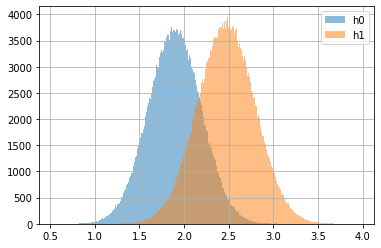

In [15]:
t, power = welch(df_r, df_m)


In [10]:
def welch_power(data_0, data_1, simu_size=1000000):
    
    # Evaluate size
    n0 = data_0.shape[0]
    n1 = data_1.shape[0]
    
    # Evaluate sample means
    m0 = data_0.mean()
    m1 = data_1.mean()
    
    # Evaluate sample standard deviation
    _s0 = data_0.std(ddof=1)
    _s1 = data_1.std(ddof=1)
    
    # Evaluate standard error
    s0 = _s0 / np.sqrt(n0)
    s1 = _s1 / np.sqrt(n1)
    
    # Make sure DOF is greater than 1,000 to estimate normal distribution
    dof = (_s0**2/n0 + _s1**2/n1) ** 2 / (_s0 ** 4 / n0**2 / (n0-1) + _s1 ** 4 / n1**2 / (n1-1))
    assert dof > 1000, "Not enough samples to estimate for normal distribution"
    
    # Simulate
    dist_0 = np.random.normal(m0, s0, simu_size)
    dist_1 = np.random.normal(m1, s1, simu_size)
    
    # Get critical value
    c0 = 1.96 * s0 + m0 # alpha = 0.05
    
    # Calculate power
    power = (dist_1 > c0).sum() / simu_size
    
    return power

In [37]:
data_0 = df_r.inc_sales.values
data_1 = df_m.inc_sales.values
welch_power(data_0, data_1, simu_size=1000000)

0.04363

### Mann-Whitney U test
Based on Zhao et al (2008) - https://onlinelibrary.wiley.com/doi/abs/10.1002/sim.2912

In [22]:
import scipy
from scipy.stats import mannwhitneyu

In [80]:
df_r = _df[_df['model'] == 'R']
df_m = _df[_df['model'] == 'M']

df_r = df_r.sample(n=100000, random_state=1)
df_m = df_m.sample(n=100000, random_state=1)

In [81]:
def zhao_mannwhitneyu_power(data_0, data_1, resolution=0):
    z_a = 1.96 # alpha = 0.05
    _z_b = 1.28 # beta = 0.1  
    
    # build contigency data structure as per Table I in Zhao et al. (2008)
    dfs = []
    for data in [data_0, data_1]:
        y = np.around(data, resolution)
        dfs.append(pd.DataFrame({'metric': y}))
    
    classes = np.concatenate((dfs[0]['metric'], dfs[1]['metric']), axis=None)
    classes_df = pd.DataFrame({'class': pd.unique(classes)}).sort_values(by='class').reset_index(drop=True)
    
    contigency_dfs = []
    for df in dfs:
        contigency_df = classes_df.merge(df, how='left', left_on='class', right_on='metric')
        contigency_df['freq'] = contigency_df['metric'].apply(lambda x: 0 if pd.isna(x) else 1)
        contigency_df = contigency_df.groupby('class').aggregate({'freq':'sum'}).reset_index()
        contigency_dfs.append(contigency_df)
        
    contigency_df = contigency_dfs[0].merge(contigency_dfs[1], on='class')
    p = contigency_df['freq_x'] / contigency_df['freq_x'].sum()
    q = contigency_df['freq_y'] / contigency_df['freq_y'].sum()
    t = len(data_1) / (len(data_0) + len(data_1))
        
    # component of sample size formula
    num_0 = (z_a + _z_b) ** 2
    num_1 = 1 - np.sum(((1-t) * p + t * q)**3)
    num = num_0 * num_1

    den_0 = 12 * t * (1-t)
    den_1 = 0
    for i in range(1, len(p)):
        den_1 += p[i] * np.sum(q[:i])
    den_2 = 0.5 * np.sum(p*q)
    den = den_0 * (den_1 + den_2 - 0.5) ** 2
    
    # compute sample size (if unknown and instead we have alpha, beta, p, and q)
    _N = num / den 
    
    # use above to compute the power instead
    N = len(data_0) + len(data_1)
    z_b = np.sqrt(N * den / num_1) - z_a
    power =  1 - scipy.stats.norm.sf(z_b)
        
    return power
    

power = zhao_mannwhitneyu_power(df_r.inc_sales.values, df_m.inc_sales.values)
_, p = scipy.stats.mannwhitneyu(df_r.inc_sales, df_m.inc_sales, alternative='less')

16405.872638141504
9.352545531098723


In [56]:
z_a = 1.96 # alpha = 0.0
z_b = 0.84

p = np.array([0.66, 0.15, 0.19])
q = np.array([0.61, 0.23, 0.16])

In [57]:
# component of sample size calculation
t = 0.53
num_0 = (z_a + z_b) ** 2
num_1 = 1 - np.sum(((1-t) * p + t * q)**3)
num = num_0 * num_1

den_0 = 12 * t * (1-t)
den_1 = 0
for i in range(1, len(p)):
    den_1 += p[i] * np.sum(q[:i])
den_2 = 0.5 * np.sum(p*q)
den = den_0 * (den_1 + den_2 - 0.5) ** 2

In [59]:
num / den

8380.208682778446